## Set things up

In [1]:
%matplotlib inline
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
RAW_DATA_SOURCE = "C:/Users/sbranchett/Data/WiFi_data/WiFiAccessPoint.csv"
CLEAN_DATA_SOURCE = "CleanedWiFiAccessPoint.csv"

## Read in data

In [3]:
def load_wifi_data(path):
    """
    Read WiFi clientCount .csv file and sum the clientCounts over building and timestamp, bucketed to 5 minutes
    
    Input: filepath the .csv file
    Output: Dataframe with "building", "time_bucket", "clientCount"
    Columns "building" generated from "locationHierarchy", and "time_bucket" generated from "timestamp"
    """
    all_data = pd.read_csv(path, delimiter=",")
    all_data = all_data.rename(columns=lambda x: x.strip())  # get rid of extra spaces in column names

    sum_clientCounts = all_data["clientCount"].sum()
    
    # extract building from 'locationHierarchy' string and deal with unknown buildings
    all_data["building"] = all_data["locationHierarchy"].str.split(" > ",expand=True)[1]
    all_data["building"] = all_data["building"].fillna("Unknown")

    # convert timestamp from epoch milliseconds to 5 minute buckets (1000 milliseconds * 60 seconds * 5 minutes)
    all_data["time_bucket"] = all_data["timestamp"].apply(lambda d: 300000*int(d/300000))
    
    # keep only the interesting columns
    all_data = all_data[["time_bucket", "building", "clientCount"]]
    
    # sum data over buildings and time buckets
    all_data = all_data.groupby(["time_bucket", "building"]).sum()  # sort on time first so that new data keeps sequence
    
    assert sum_clientCounts == all_data["clientCount"].sum()  # check that no clientCounts went missing

    return all_data

# if possible read in the cleaned data, otherwise clean the raw data and save
if os.path.isfile(CLEAN_DATA_SOURCE):
    all_data = pd.read_csv(CLEAN_DATA_SOURCE, delimiter=",")
else:
    all_data = load_wifi_data(RAW_DATA_SOURCE)
    all_data.to_csv(CLEAN_DATA_SOURCE)

print(all_data["clientCount"].sum())  # should be 3597531

3597531


In [4]:
all_data = all_data.reset_index().drop("index", axis=1)  # get rid of multiindex for StratifiedShuffleSplit
print(all_data)

         time_bucket               building  clientCount
0      1620991800000      03-Science Center           34
1      1620991800000             05-TNW-BIO            1
2      1620991800000             08-BK-City            2
3      1620991800000   19-Studuitzendbureau           13
4      1620991800000                20-Aula           32
...              ...                    ...          ...
78161  1621608600000                 64-HSL           10
78162  1621608600000          66-Fellowship          126
78163  1621608600000  Katalyse Labaratorium            8
78164  1621608600000                Unknown           32
78165  1621608600000           VLL-LAB(TNO)           11

[78166 rows x 3 columns]


## Separate Test Set stratified over buildings

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_data, all_data["building"]):
    strat_train_set = all_data.loc[train_index]
    strat_test_set = all_data.loc[test_index]

print(strat_train_set)

         time_bucket                           building  clientCount
11688  1621083900000                    37-Sportcentrum           15
61351  1621476000000                         36-ESP-Lab            1
55780  1621431900000                      66-Fellowship          101
26158  1621198200000                          32-OCP-IO           12
34879  1621266900000                             64-HSL           16
...              ...                                ...          ...
50892  1621393500000                            28- WNI            4
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e           247
4160   1621024500000                      35-Drebbelweg            2
56082  1621434300000                          63-Simona            8
55786  1621432200000                         08-BK-City          670

[62532 rows x 3 columns]


## Create Work days and Student days

In [6]:
uni_hols = (datetime.date(year=2021, month=5, day=5),
            datetime.date(year=2021, month=5, day=13),
            datetime.date(year=2021, month=5, day=14),
            datetime.date(year=2021, month=5, day=24)
           )  # National Holidays and Collective Free days

def roster(date):
    # categorise the days of the academic year at TU Delft between 1 May 2021 and 29 August 2021
    
    if (date > datetime.date(year=2021, month=5, day=16)) and \
       (date < datetime.date(year=2021, month=5, day=22)):
        categorie = "Exam_BSc"
    elif (date > datetime.date(year=2021, month=6, day=15)) and \
         (date < datetime.date(year=2021, month=6, day=19)):
        categorie = "Study_mixed"
    elif (date > datetime.date(year=2021, month=6, day=22)) and \
         (date < datetime.date(year=2021, month=6, day=26)):
        categorie = "Exam_mixed"
    elif (date > datetime.date(year=2021, month=6, day=29)) and \
         (date < datetime.date(year=2021, month=7, day=3)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=8, day=8)) and \
         (date < datetime.date(year=2021, month=8, day=14)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=7, day=4)):
        categorie = "Free"
    else:
        categorie = "Learn"
    return categorie

## Separate predictions and labels

In [7]:
crowd = strat_train_set.drop("clientCount", axis=1)
crowd_labels = strat_train_set["clientCount"].copy()
print(crowd)

         time_bucket                           building
11688  1621083900000                    37-Sportcentrum
61351  1621476000000                         36-ESP-Lab
55780  1621431900000                      66-Fellowship
26158  1621198200000                          32-OCP-IO
34879  1621266900000                             64-HSL
...              ...                                ...
50892  1621393500000                            28- WNI
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e 
4160   1621024500000                      35-Drebbelweg
56082  1621434300000                          63-Simona
55786  1621432200000                         08-BK-City

[62532 rows x 2 columns]


In [8]:
assert crowd.isnull().values.any() == False  # check there are no missing values

## Build Transformers

In [9]:
# specify which extra attributes to add to the data
# want to treat these as hyperparameters for grid search
add_day_of_week=True
add_time_of_day=True
add_uni_hols=True
add_weekend=True
add_academic_yr=True

In [10]:
# Set up categories for OneHotEncoder.
# This is needed later for the transformation of small sets that do not contain all the categories.

buildings = list(set(all_data["building"].values))  # get a list of all buildings
all_categories = [buildings]
if add_academic_yr:
    rosters = ["Exam_BSc", "Study_mixed", "Exam_mixed", "Exam", "Free", "Learn"]  # get a list of all roster categories, SEB could be improved
    all_categories.append(rosters)
    
print(all_categories)

[['34-3ME', '50-TNW-RID', '22-TNW-TN', '36-EWI LB_K t/m 3 & HB_K  t/m 2e ', '30-IKC_ISD-FMVG', '64-HSL', '25-GreenVillage', '60-LMS', '36-ESP-Lab', '23-CITG', '30-O S', '45-LSL', 'Unknown', '63-Simona', '28- WNI', '62-LR', '35-Drebbelweg', '32a- Learninglab', '38-Cultureel Centrum', '26-Bouwcampus', '31-TBM', '21-BTUD', '03-Science Center', '05-TNW-BIO', '19-Studuitzendbureau', '33-Pulse', '08-BK-City', '37-Sportcentrum', '46-P E lab', '66-Fellowship', 'Katalyse Labaratorium', '43-EGM', 'VLL-LAB(TNO)', '58-TNW-Zuid', '61-Vliegtuighal', '20-Aula', '36-EWI-HB', '32-OCP-IO'], ['Exam_BSc', 'Study_mixed', 'Exam_mixed', 'Exam', 'Free', 'Learn']]


In [11]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_day_of_week=True, add_time_of_day=True, add_uni_hols=True, add_weekend=True, add_academic_yr=True):
        self.add_day_of_week = add_day_of_week
        self.add_time_of_day = add_time_of_day
        self.add_uni_hols = add_uni_hols
        self.add_weekend = add_weekend
        self.add_academic_yr = add_academic_yr
        self.num_attribs = ["time_bucket"]
        self.cat_attribs = ["building"]
        if self.add_day_of_week:
            self.num_attribs.extend(["day_of_week"])
        if self.add_time_of_day:
            self.num_attribs.extend(["time_of_day"])
        if self.add_uni_hols:
            self.num_attribs.extend(["hols"])
        if self.add_weekend:
            self.num_attribs.extend(["weekend"])
        if self.add_academic_yr:
            self.cat_attribs.extend(["academic_yr"])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_trans = X.copy()
        if self.add_day_of_week:
            X_trans["day_of_week"] = X["time_bucket"].apply(lambda d: datetime.datetime.fromtimestamp(d/1000).weekday())
        if self.add_time_of_day:
            X_trans["time_of_day"] = X["time_bucket"].apply(lambda d: int(d%86400000))
        if self.add_uni_hols:
            X_trans["hols"] = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).date() in uni_hols else 0.)
        if self.add_weekend:
            X_trans["weekend"] = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).weekday() > 4 else 0.)
        if self.add_academic_yr:
            X_trans["academic_yr"] = X["time_bucket"].apply(lambda d: roster(datetime.datetime.fromtimestamp(d/1000).date()))
        return X_trans

In [12]:
crowd_attributes = CombinedAttributesAdder(add_day_of_week, add_time_of_day, add_uni_hols, add_weekend, add_academic_yr)
crowd_extra_attribs = crowd_attributes.transform(crowd)
print(crowd_extra_attribs)
print(crowd_attributes.num_attribs)
print(crowd_attributes.cat_attribs)

         time_bucket                           building  day_of_week  \
11688  1621083900000                    37-Sportcentrum            5   
61351  1621476000000                         36-ESP-Lab            3   
55780  1621431900000                      66-Fellowship            2   
26158  1621198200000                          32-OCP-IO            6   
34879  1621266900000                             64-HSL            0   
...              ...                                ...          ...   
50892  1621393500000                            28- WNI            2   
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e             0   
4160   1621024500000                      35-Drebbelweg            4   
56082  1621434300000                          63-Simona            2   
55786  1621432200000                         08-BK-City            2   

       time_of_day  hols  weekend academic_yr  
11688     47100000   0.0      1.0       Learn  
61351      7200000   0.0      0.0    Ex

In [13]:
# build a pipeline for the numerical attributes
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# build a pipeline for the categorical attributes
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(categories=all_categories))
])

In [14]:
# combine the pipelines based on column type
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, crowd_attributes.num_attribs),
    ("cat", cat_pipeline, crowd_attributes.cat_attribs),
])

In [15]:
crowd_prepared = full_pipeline.fit_transform(crowd_extra_attribs)  # this gives a sparse matrix, sometimes!
print(crowd_prepared.toarray())
print(crowd_prepared.toarray().shape)

[[-1.21669404  0.9978856   0.16027025 ...  0.          0.
   1.        ]
 [ 0.98681612 -0.00801088 -1.45222465 ...  0.          0.
   0.        ]
 [ 0.73898445 -0.51095912  0.25726243 ...  0.          0.
   0.        ]
 ...
 [-1.55050812  0.49493736  1.25143222 ...  0.          0.
   1.        ]
 [ 0.75247189 -0.51095912  0.3542546  ...  0.          0.
   0.        ]
 [ 0.74067038 -0.51095912  0.26938645 ...  0.          0.
   0.        ]]
(62532, 49)


## Select and Train a model

In [16]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [17]:
lin_reg = LinearRegression()
lin_reg.fit(crowd_prepared, crowd_labels)

LinearRegression()

In [18]:
# prepare a small data set to test
some_data = crowd.iloc[:5]
some_labels = crowd_labels[:5]

some_data_extra_attribs = crowd_attributes.transform(some_data)
print(some_data_extra_attribs)

some_data_prepared = full_pipeline.transform(some_data_extra_attribs)  # this gives a sparse matrix!
print(some_data_prepared)
print(some_data_prepared.shape)

         time_bucket         building  day_of_week  time_of_day  hols  \
11688  1621083900000  37-Sportcentrum            5     47100000   0.0   
61351  1621476000000       36-ESP-Lab            3      7200000   0.0   
55780  1621431900000    66-Fellowship            2     49500000   0.0   
26158  1621198200000        32-OCP-IO            6     75000000   0.0   
34879  1621266900000           64-HSL            0     57300000   0.0   

       weekend academic_yr  
11688      1.0       Learn  
61351      0.0    Exam_BSc  
55780      0.0    Exam_BSc  
26158      1.0       Learn  
34879      0.0    Exam_BSc  
  (0, 0)	-1.2166940375438953
  (0, 1)	0.9978855998874533
  (0, 2)	0.16027025456755256
  (0, 3)	-0.2542919960323025
  (0, 4)	1.6054750708437873
  (0, 32)	1.0
  (0, 48)	1.0
  (1, 0)	0.9868161220193287
  (1, 1)	-0.008010881593061129
  (1, 2)	-1.4522246509775483
  (1, 3)	-0.2542919960323025
  (1, 4)	-0.6228685939510924
  (1, 13)	1.0
  (1, 43)	1.0
  (2, 0)	0.7389844514334113
  (2, 1)	-0.51

In [19]:
# check out the predictions
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [-6.37154127 20.54789177 56.39221755 86.51314906 31.05846782]
Labels: [15, 1, 101, 12, 16]


In [20]:
crowd_predictions = lin_reg.predict(crowd_prepared)
lin_mse = mean_squared_error(crowd_labels, crowd_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

97.30959112641578


In [21]:
lin_scores = cross_val_score(lin_reg, crowd_prepared, crowd_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 95.40334995  95.58231466  95.3568397   97.98275818 105.73822232
  92.3158389   97.21878146  98.41494309 100.75946891  94.7687537 ]
Mean: 97.35412708558772
Standard deviation: 3.5557100982295986


In [22]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(crowd_prepared, crowd_labels)

crowd_predictions = tree_reg.predict(crowd_prepared)
tree_mse = mean_squared_error(crowd_labels, crowd_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [23]:
scores = cross_val_score(tree_reg, crowd_prepared, crowd_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [6.45519105 5.59599484 5.06185946 6.43574696 6.03701467 5.47255192
 6.10293389 5.76061727 6.47895139 5.76713753]
Mean: 5.916799899377532
Standard deviation: 0.4474673141878726


In [24]:
# check out the predictions
print("Predictions:", tree_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 15.   1. 101.  12.  16.]
Labels: [15, 1, 101, 12, 16]


## Let's take a look at how are predictions are doing

In [25]:
first_time_stamp = all_data["time_bucket"].min()
last_time_stamp = all_data["time_bucket"].max()

a_building = "20-Aula"
a_building_data = strat_train_set.loc[strat_train_set["building"] == a_building]

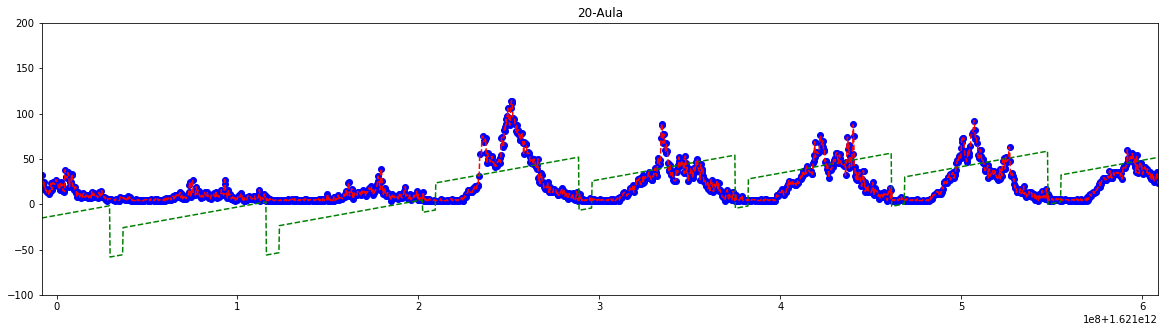

In [26]:
times = list(range(first_time_stamp, last_time_stamp + 300000, 300000))

test = pd.DataFrame()
test["time_bucket"] = times
test["building"] = a_building

test_extra_attribs = crowd_attributes.transform(test)
test_prepared = full_pipeline.transform(test_extra_attribs)

lin_preds = lin_reg.predict(test_prepared)
tree_preds = tree_reg.predict(test_prepared)
xes = test["time_bucket"]

plt.figure(figsize=(20,5))
plt.title(a_building)
plt.axis([first_time_stamp, last_time_stamp, -100, 200])
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', times, lin_preds, 'g--', times, tree_preds, 'r--')
plt.show()

## See what happens when we try to predict the future

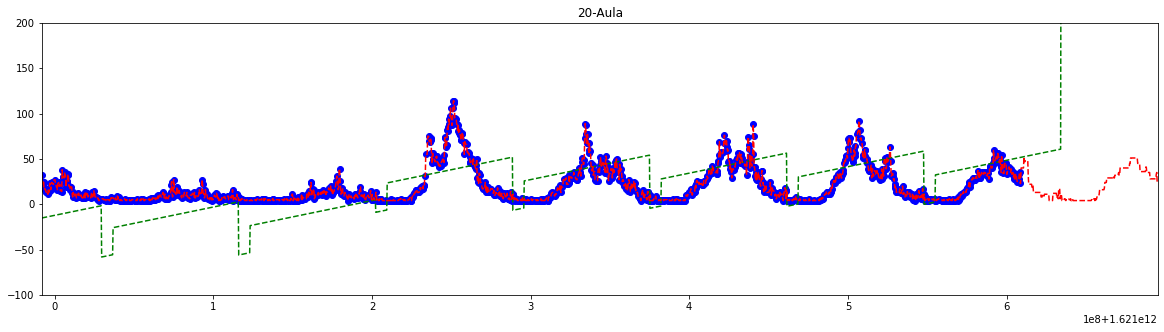

In [27]:
extra_days = 1
latest_time_stamp = last_time_stamp + extra_days*86400000 + 300000
times = list(range(first_time_stamp, latest_time_stamp, 300000))

test = pd.DataFrame()
test["time_bucket"] = times
test["building"] = a_building
test_extra_attribs = crowd_attributes.transform(test)
test_prepared = full_pipeline.transform(test_extra_attribs)
lin_preds = lin_reg.predict(test_prepared)
tree_preds = tree_reg.predict(test_prepared)

plt.figure(figsize=(20,5))
plt.title(a_building)
plt.axis([first_time_stamp, latest_time_stamp, -100, 200])
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', times, lin_preds, 'g--', times, tree_preds, 'r--')
plt.show()

## Make prettier graph for blog

In [ ]:
# To make the graph with extra attributes, change these varibales in the Build Transformers section
# then KERNEL -> RESTART AND RUN ALL
# add_day_of_week=True
# add_time_of_day=True
# add_uni_hols=True
# add_weekend=True
add_academic_yr=True

In [28]:
extra_days = 2
latest_time_stamp = last_time_stamp + extra_days*86400000 + 300000
times = list(range(first_time_stamp, latest_time_stamp, 300000))

day_in_milliseconds = 24 * 60 * 60 * 1000
xticks = []
xlabels = []
for eptime in range(first_time_stamp, latest_time_stamp, day_in_milliseconds):
    xticks.append(eptime)
    xlabels.append(datetime.date.fromtimestamp(int(eptime/1000)))
ymin = -25
ymax = 125
yticks = range(ymin, ymax+1, 25)

a_building = "20-Aula"
a_building_data = strat_train_set.loc[strat_train_set["building"] == a_building]

fontsize = 14
fslegend = 20

title = "Aula"
if add_day_of_week or add_time_of_day or add_uni_hols or add_weekend or add_academic_yr:
    title = "Aula - extra attributes"

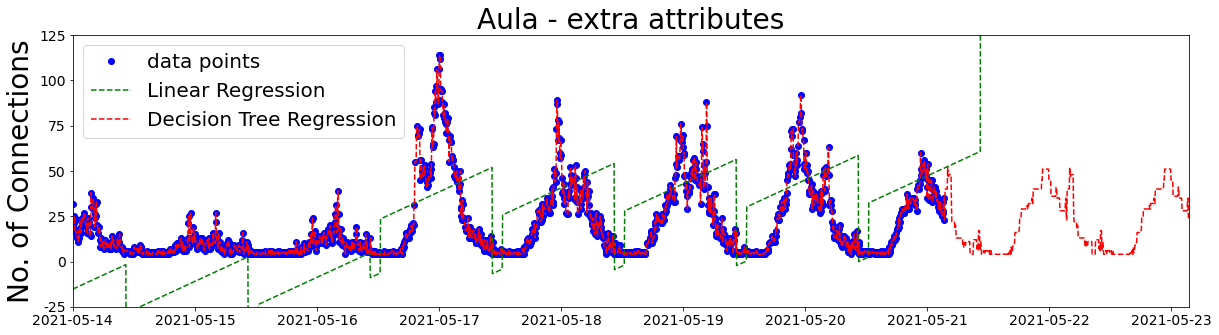

In [29]:
test = pd.DataFrame()
test["time_bucket"] = times
test["building"] = a_building
test_extra_attribs = crowd_attributes.transform(test)
test_prepared = full_pipeline.transform(test_extra_attribs)
lin_preds = lin_reg.predict(test_prepared)
tree_preds = tree_reg.predict(test_prepared)

plt.figure(figsize=(20,5))
plt.title(title, fontsize=2*fontsize)
plt.axis([first_time_stamp, latest_time_stamp, ymin, ymax])
plt.xticks(ticks=xticks, labels=xlabels, fontsize=fontsize) 
plt.yticks(ticks=yticks, labels=yticks, fontsize=fontsize)
plt.ylabel("No. of Connections", fontsize=2*fontsize)
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', label="data points")
plt.plot(times, lin_preds, 'g--', label="Linear Regression")
plt.plot(times, tree_preds, 'r--', label="Decision Tree Regression")

plt.legend(loc='upper left', fontsize=fslegend)
plt.show()

Save what we have so far:
```
from joblib import dump

dump(lin_reg, "lin_reg.joblib")
dump(tree_reg, "tree_reg.joblib")
dump(forest_reg, "forest_reg.joblib")
```